In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd
import numpy as np
# Data manipulation and numerical operations

import matplotlib.pyplot as plt
#  Visualization of feature importance

import joblib  # Model Saving/Loading
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, recall_score, f1_score

In [12]:
file_path = '/content/drive/MyDrive/css_features_all.csv'
df = pd.read_csv(file_path)

In [13]:
# Preprocessing
# Drop unnecessary columns, sinces filename is useless for predciting....
columns_to_drop = ['Unnamed: 0', 'file_number']
df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

In [14]:
# Handle missing values properly
df_cleaned.dropna(inplace=True)  # Ensures we do not have NaN values

#Identify Specific Code Smell Issues
smell_thresholds = df_cleaned.mean() + df_cleaned.std()
# df_cleaned.mean(): Computes the average value of each feature across all CSS files.
# df_cleaned.std(): Computes the standard deviation (which measures variability).
# Threshold = Mean + Standard Deviation

df_smells = df_cleaned > smell_thresholds  # Identify features exceeding thresholds
# Compares each feature value in the dataset against its corresponding threshold.

def count_code_smells(row):
    return row.sum()

df_cleaned['Total_Code_Smells'] = df_smells.apply(count_code_smells, axis=1)
# Counts the number of True values (code smells) in each row (i.e., per CSS file).

def identify_code_smells(row):
    return list(row[row].index)

df_cleaned['Code_Smell_Types'] = df_smells.apply(identify_code_smells, axis=1)
# Adds another new column, Code_Smell_Types, listing the exact features where code smells were found.


In [15]:
# Normalize Features, Ensures all features are on the same scale, improving model performance
scaler = StandardScaler()
feature_columns = [col for col in df_cleaned.columns if col not in ['Total_Code_Smells', 'Code_Smell_Types']]
X_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[feature_columns]), columns=feature_columns)

In [16]:
# Train a Machine Learning Model to Predict Number of Code Smells
X = X_scaled
y = df_cleaned['Total_Code_Smells']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Handle any NaN values in predictions
y_pred = np.nan_to_num(y_pred)

# Inputs (X): Normalized CSS feature data.
# Target (y): Total code smells to be predicted.
# Model: Random Forest Regressor
# Train-Test Split: 80% training, 20% testing for evaluation.

In [18]:
y_pred_binary = np.where(y_pred > 0, 1, 0)
y_test_binary = np.where(y_test > 0, 1, 0)

# Model Evaluation
print("\nCSS Code Smell Detector Model Evaluation ---------")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
print("Model Accuracy:", max(0, r2_score(y_test, y_pred) * 100), "%")  # Ensuring non-negative accuracy
print("Recall:", recall_score(y_test_binary, y_pred_binary))
print("F1 Score:", f1_score(y_test_binary, y_pred_binary))
print("--------------------------------------------------\n")
# MAE: Measures average prediction error.
# R² Score: Indicates how well the model predicts code smells (higher is better).
# Accuracy: Non-negative version of R² expressed as a percentage.
# Recall: Measures how many actual code smells were correctly identified.
# F1 Score: Balances precision and recall, useful for imbalanced datasets.


CSS Code Smell Detector Model Evaluation ---------
Mean Absolute Error: 0.4766336633663366
R2 Score: 0.8871898208308723
Model Accuracy: 88.71898208308723 %
Recall: 0.975609756097561
F1 Score: 0.898876404494382
--------------------------------------------------



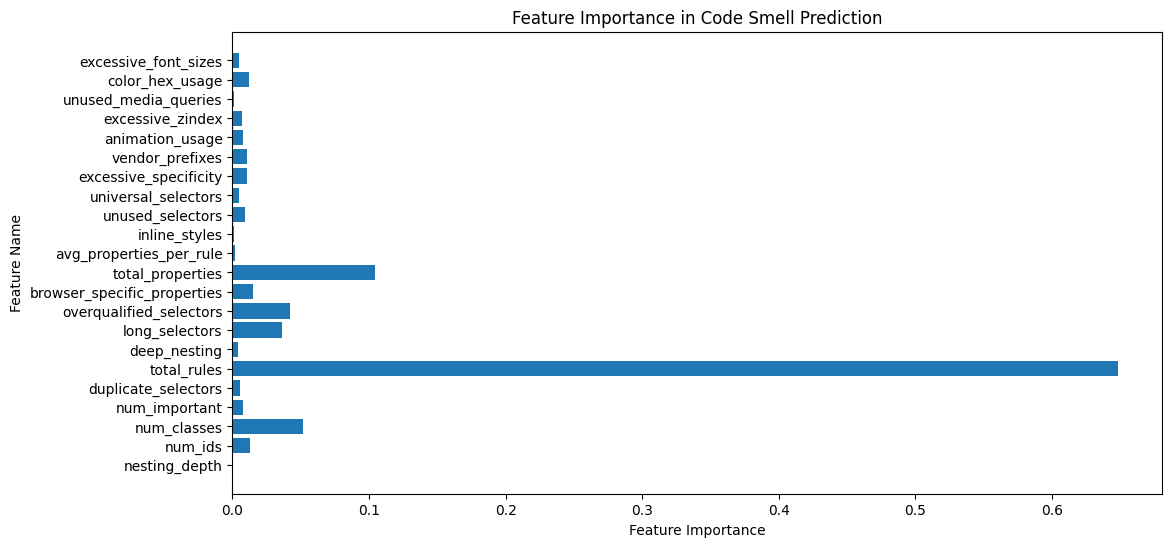

In [19]:
# Visualizes which features contribute most to code smell detection.
plt.figure(figsize=(12, 6))
plt.barh(feature_columns, clf.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Code Smell Prediction")
plt.show()

In [ ]:
def display_summary(index):
    print(f"CSS File {index} Analysis")
    print("Total Code Smells Detected:", df_cleaned.loc[index, 'Total_Code_Smells'])
    print("Types of Code Smells Present:", df_cleaned.loc[index, 'Code_Smell_Types'])
    print("--------------------------------------------------\n")

# Display sample analysis for first 5 entries
for i in range(min(5, len(df_cleaned))):  # Avoid out-of-range errors
    display_summary(i)

# Shows analysis for the first 5 CSS files in the dataset, allows us to get a clear understanding on how the model has predicted the CSS files.

In [20]:
# Save the Model
model_path = '/content/drive/MyDrive/css_smell_predictor_all.pkl'  # Save locally if needed
joblib.dump(clf, model_path)
print(f"\n✅ Model saved to {model_path}")


✅ Model saved to /content/drive/MyDrive/css_smell_predictor_all.pkl
